In [2]:
import json
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
directory = "./data" #"data/parallel/20_30"

# open all json files and parse them
data = []
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        with open(os.path.join(directory, filename)) as f:
            data.append(json.load(f))

Text(0.5, 0, 'Agent 1 policy')

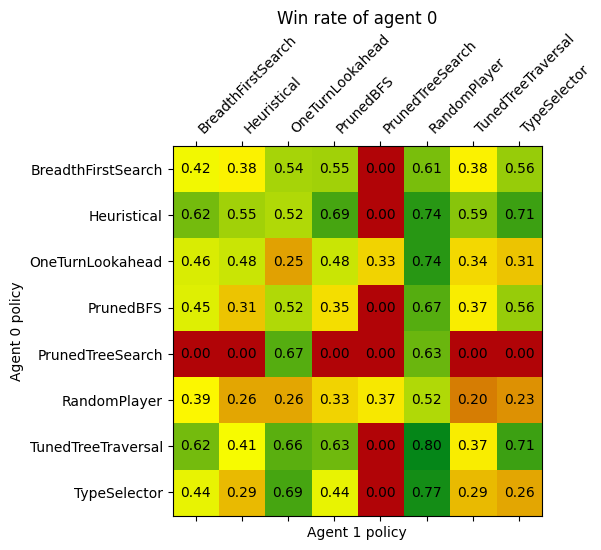

In [ ]:
# WIN RATE
# map all data in the grid
# they all the combination of policies versus a different policy
# I want to map them in a grid showing the win rate

# get all the policies
policies = set()
for d in data:
    policies.add(d["policies_names"][0])
policies = list(policies)
policies.sort()
index_policy = {k: i for i, k in enumerate(policies)}

# create the grid
grid = np.zeros((len(policies), len(policies)))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    # calculate the win rate
    wins = 0
    for battle in d["battles"]:
        if battle["result"] == 0:
            wins += 1
    grid[x, y] = wins / len(d["battles"])
    grid[y, x] = 1 - grid[x, y]

# Define the custom colormap
colors = ['#b10407', '#ffff00', '#058618']  # R -> Y -> G
n_bins = 100  # Discretize the interpolation into bins
cmap_name = 'r_y_g'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
n = len(policies)
fig, ax = plt.subplots()
cax = ax.matshow(grid, cmap=cm)
for i in range(n):
    for j in range(n):
        ax.text(j, i, f"{grid[i][j]:.2f}", ha='center', va='center', color='black')
plt.xticks(range(n), policies, rotation=45, ha='left')
plt.yticks(range(n), policies)
plt.title("Win rate of agent 0")
plt.ylabel("Agent 0 policy")
plt.xlabel("Agent 1 policy")


Text(0.5, 0, 'Agent 1 policy')

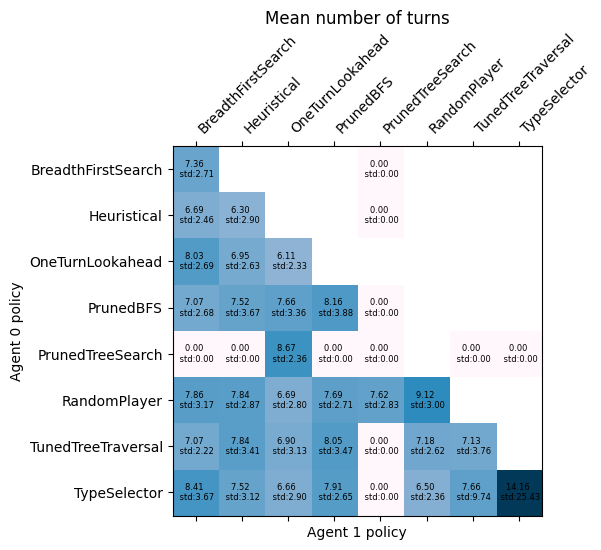

In [ ]:
# MEAN NUMBER OF TURNS

turns = np.zeros((len(policies), len(policies)))
turns_dev = np.zeros((len(policies), len(policies)))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    if x < y:
        x, y = y, x
    turns[y, x] = np.nan
    turns[x, y] = sum(battle["turns"] for battle in d["battles"])/d["n_battles_emulated"]
    turns_dev[y, x] = np.nan
    turns_dev[x, y] = np.std([battle["turns"] for battle in d["battles"]])


n = len(policies)
fig, ax = plt.subplots()
cax = ax.matshow(turns, cmap="PuBu")
for i in range(n):
    for j in range(n):
        if not np.isnan(turns[i, j]): 
            ax.text(j, i, f"{turns[i, j]:.2f} \n std:{turns_dev[i, j]:.2f}", ha='center', va='center', color='black', fontsize=6)
plt.xticks(range(n), policies, rotation=45, ha='left')
plt.yticks(range(n), policies)
plt.title("Mean number of turns")
plt.ylabel("Agent 0 policy")
plt.xlabel("Agent 1 policy")

Text(0.5, 0, 'Agent 1 policy')

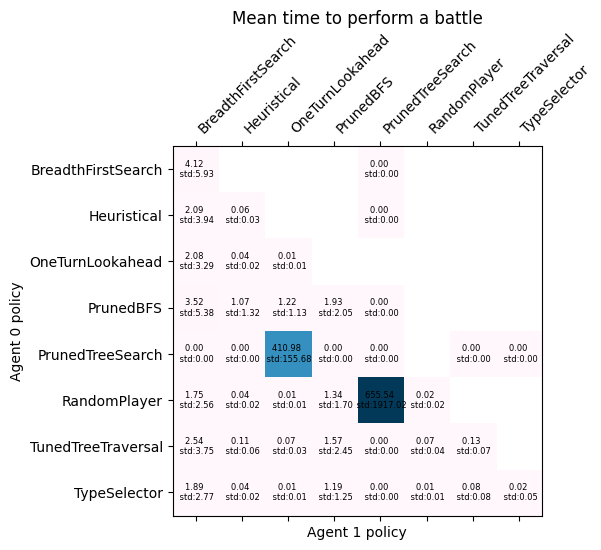

In [28]:
# MEAN TIME OF A BATTLE

time = np.zeros((len(policies), len(policies)))
time_dev = np.zeros((len(policies), len(policies)))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    if x < y:
        x, y = y, x
    time[y, x] = np.nan
    time[x, y] = sum(battle["total_time"] for battle in d["battles"])/d["n_battles_emulated"]
    time_dev[y, x] = np.nan
    time_dev[x, y] = np.std([battle["total_time"] for battle in d["battles"]])

n = len(policies)
fig, ax = plt.subplots()
cax = ax.matshow(time, cmap="PuBu")
for i in range(n):
    for j in range(n):
        if not np.isnan(time[i, j]): 
            ax.text(j, i, f"{time[i, j]:.2f} \n std:{time_dev[i, j]:.2f}", ha='center', va='center', color='black', fontsize=6)
plt.xticks(range(n), policies, rotation=45, ha='left')
plt.yticks(range(n), policies)
plt.title("Mean time to perform a battle")
plt.ylabel("Agent 0 policy")
plt.xlabel("Agent 1 policy")